Fast Gradient Signed Method (FGSM) is a whitebox adversarial attack.
<br> Whitebox means we have access to the model

In [6]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.figsize"] = (8, 8)
mpl.rcParams["axes.grid"] = False

In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet'
    )
pretrained_model.trainable = False

decode_preds = tf.keras.applications.mobilenet_v2.decode_predictions

In [8]:
def preprocess(img):
  img = tf.cast(img, tf.float32)
  img = tf.image.resize(img, (224, 224))

  img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

  img = img[None, ...]

  return img

def get_imagenet_label(probs): return decode_preds(probs, top=1)[0][0]

In [9]:
img_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

img_raw = tf.io.read_file(img_path)
img = tf.image.decode_image(img_raw)

img = preprocess(img)
img_probs = pretrained_model.predict(img)

1/1 [==============================] - 2s 2s/step


35363/35363 [==============================] - 0s 0us/step


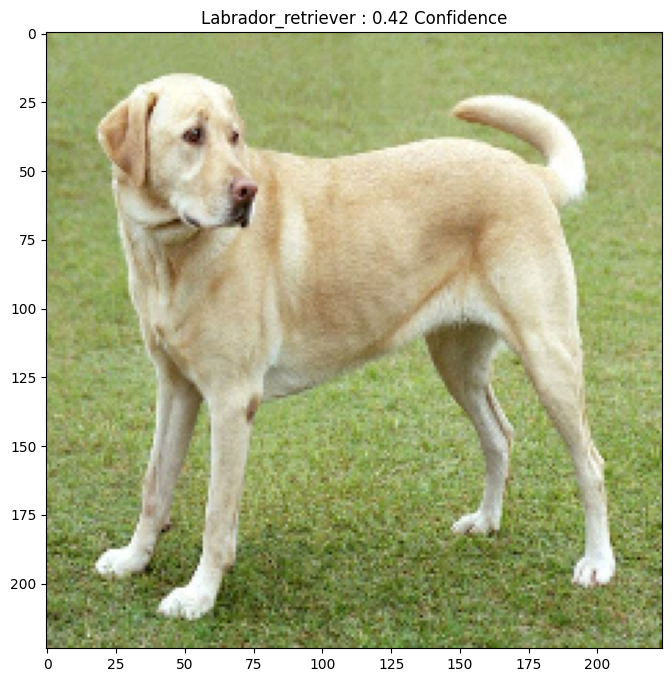

In [10]:
plt.figure()
plt.imshow(img[0]*0.5 + 0.5)  # [-1, 1] -> [0, 1]
_, img_class, class_confidence = get_imagenet_label(img_probs)
plt.title(f"{img_class} : {class_confidence:.2f} Confidence")
plt.show()

In [14]:
loss_obj = tf.keras.losses.CategoricalCrossentropy()

def create_adv_pattern(img, label):
  with tf.GradientTape() as tape:
    tape.watch(img)

    pred = pretrained_model(img)
    loss = loss_obj(label, pred)

  grads = tape.gradient(loss, img)
  signed_grads = tf.sign(grads)

  return signed_grads

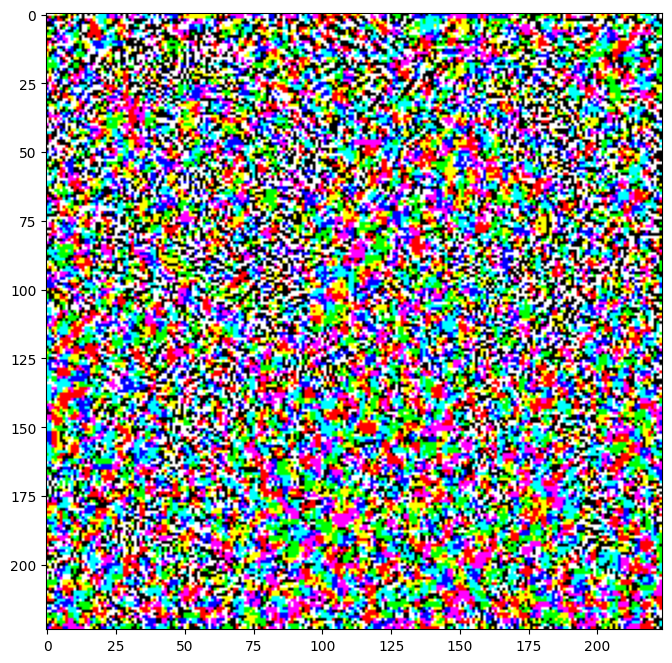

In [15]:
labrador_retriever_idx = 208
label = tf.one_hot(labrador_retriever_idx, img_probs.shape[-1])
label = tf.reshape(label, (1, img_probs.shape[-1]))

perturbations = create_adv_pattern(img, label)
plt.imshow(perturbations[0]*0.5 + 0.5)

In [16]:
def display_images(img, descr):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(img))

  plt.figure()
  plt.imshow(img[0]*0.5 + 0.5)
  plt.title(f"{descr} \n {label} : {confidence:.2f}")

  plt.show()

1/1 [==============================] - 0s 99ms/step


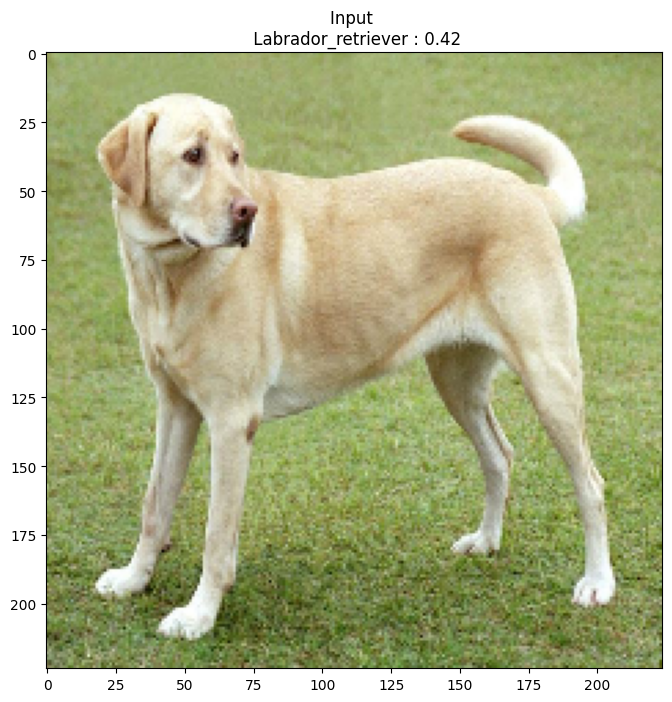

1/1 [==============================] - 0s 102ms/step


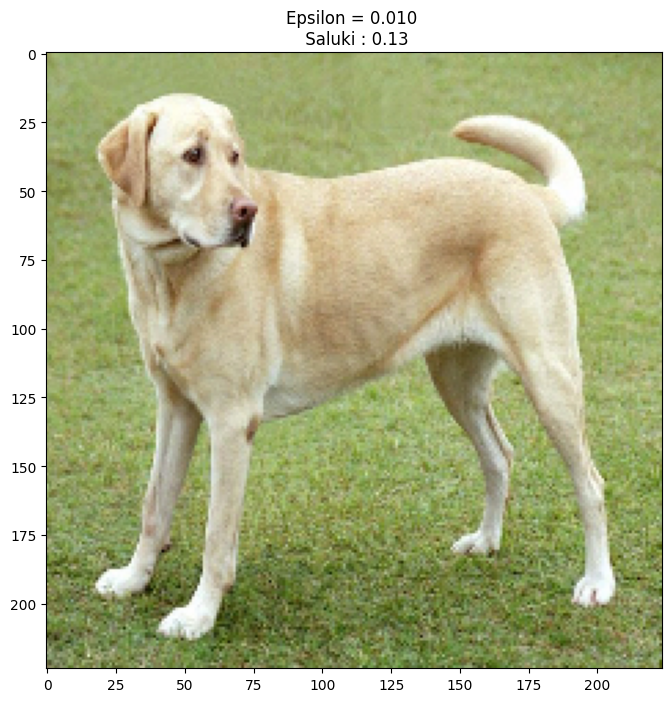

1/1 [==============================] - 0s 85ms/step


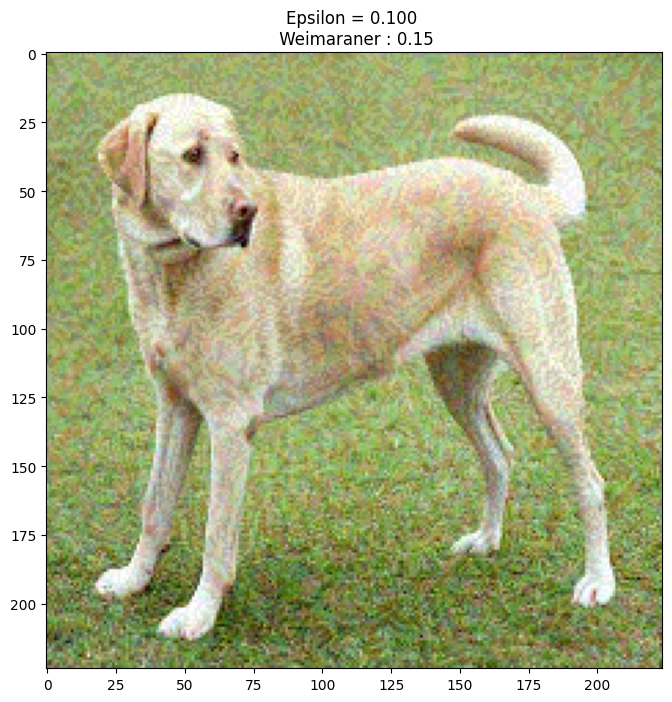

1/1 [==============================] - 0s 107ms/step


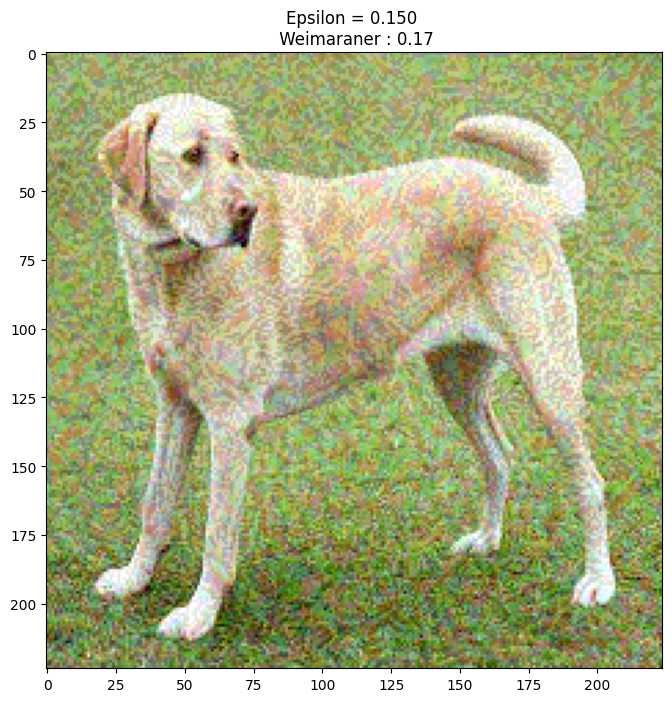

In [17]:
epsilons = [0, 0.01, 0.1, 0.15]
descrs = [(f'Epsilon = {eps:0.3f}' if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = img + eps * perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descrs[i])